<a href="https://colab.research.google.com/github/RxnAch/DeepLearning/blob/main/Norms_and_Weight_Decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U d2l

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils import data

Functions we might need while implementing Regression problems from scratch.
They are optionally created here. We can use the libraries for concise implementaion.(Available at the end of the notebook)

In [3]:
#The Squared Error Loss function
def squared_loss(y_hat,y):
  return (y_hat-y.reshape(y_hat.shape))**2 / 2
#The linear regression model
def linreg(X,w,b):
  return torch.matmul(X,w)+b

def synthetic_data(w,b,num_examples):
  #generate y = X.w+b+noise
  X = torch.normal(0,1,(num_examples,len(w)))
  y = torch.matmul(X,w)+b 
  y+= torch.normal(0,0.01,y.shape)
  return X,y.reshape((-1,1))

def load_array(data_arrays,batch_size,is_train = True):
  #construct pytorch data iterator
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset,batch_size,shuffle= is_train)

#Minibatch stochastic gradient descent.
def sgd(params,lr,batch_size):
  with torch.no_grad():
    for param in params:
      param-=lr*param.grad/batch_size
      param.grad.zero_()


In [4]:
#generate data
n_train,n_test,num_inputs,batch_size = 20,100,200,5
true_w,true_b = torch.ones((num_inputs,1))*0.01,0.05
train_data = synthetic_data(true_w,true_b,n_train)
train_iter = load_array(train_data,batch_size)
test_data = synthetic_data(true_w,true_b,n_test)
test_iter = load_array(test_data,batch_size,is_train = False)

**Implementation from Scratch**

In the following , we will implement weight decay from scratch, simply by adding the squared L2 penalty to the original target function.

In [5]:
#Initializing the Model Parameters(randomly)
def init_params():
  w = torch.normal(0,1,size= (num_inputs,1),requires_grad = True)
  b = torch.zeros(1,requires_grad=True)
  return [w,b]

**Defining L2 norm penalty**

Perhaps the most convenient way to implement this penalty is to square them and sum them up.

In [6]:
def l2_penalty(w):
  return torch.sum(w.pow(2))/2

**Defining the training Loop**



In [7]:
def train(lambd):
  w,b = init_params()
  net,loss = lambda X: linreg(X,w,b),squared_loss
  num_epochs,lr = 100,0.003
  animator = d2l.Animator(xlabel = 'epochs',ylabel = 'loss',yscale = 'log',
                          xlim = [5,num_epochs],legend = ['train','test'])
  for epoch in range(num_epochs):
    for X,y in train_iter:
      l = loss(net(X),y)+lambd*l2_penalty(w)
      l.sum().backward()
      sgd([w,b],lr,batch_size) #updates the parameters
    if(epoch+1)%5==0:
      animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                            d2l.evaluate_loss(net,test_iter,loss)))

  print('L2 norm of w: ',torch.norm(w).item())

**Training without Regularization**

When lambd=0,we disable weight decay. Note that we overfit badly,decreasing the training error but not the test error.

L2 norm of w:  12.944293975830078


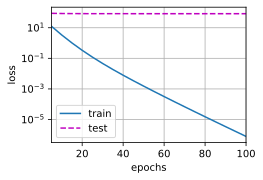

In [8]:
#Training without regularization
train(lambd=0)

**Using weight Decay**
Below, we run substantial weight decay. Note that the training error increases but the test error decreases.

L2 norm of w:  0.37104174494743347


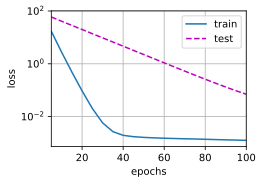

In [9]:
train(lambd=3)

**Concise Implementation**

In the following code, we specify the weight decay hyperparameter directly through weight_decay when instantiating our optimizer. By default, PyTorch decays both weights and biases simultaneously. Here we only set weight_decay for the weight, so the bias parameter  b  will not decay.

In [13]:
def train_concise(wd):
  net = nn.Sequential(nn.Linear(num_inputs,1))
  for param in net.parameters():
    param.data.normal_()
  loss = nn.MSELoss()
  num_epochs,lr = 100,0.003
  trainer = torch.optim.SGD([{
      "params":net[0].weight,
      'weight_decay':wd},{
          "params" : net[0].bias}],lr=lr)
  animator = d2l.Animator(xlabel= 'epochs',ylabel = 'loss',yscale ='log',
                         xlim = [5,num_epochs],legend = ['train','test'])
  for epoch in range(num_epochs):
    for X,y in train_iter:
      trainer.zero_grad()
      l = loss(net(X),y)
      l.backward()
      trainer.step() #Updates the parameters
    if(epoch+1)%5 == 0:
      animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                            d2l.evaluate_loss(net,test_iter,loss)))
  print('L2 norm of W: ', net[0].weight.norm().item())


The plots look identical to those when we implemented weight decay from scratch. However, they run appreciably faster and are easier to implement, a benefit that will become more pronounced for larger problems.

L2 norm of W:  13.055301666259766


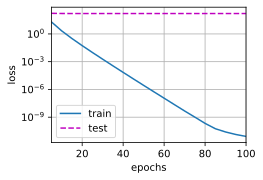

In [14]:
train_concise(0)

L2 norm of W:  0.3649226129055023


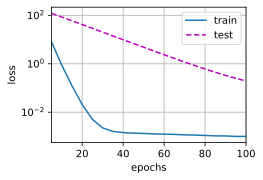

In [15]:
train_concise(3)